# PCA and PCR (Principal Components Regression)

PCA is a method used frequently for dimension reduction and to "eliminate collinearity" for regression. Here we'll perform PCA on an image and then reconstruct the image to see how PCA discards information. This will also serve to demonstrate how PCA can capture a significant amount of variance in the original data using its orthogonal projections. We'll also perform principal components regression (regression on the principal components of a data set) and transform the PC components back to beta coefficients in the X space of our original data.

## PCA

Let's open an image on which we'll perform PCA. We'll use this great image of Kenny G riding on a bicycle.

In [90]:
from PIL import Image  # Python Imaging Library
import numpy as np
f = Image.open("kenny_g_bicycle.jpg")
arr = np.asarray(f)
arr.shape

(594, 426, 3)

We now have the RGB as the first 3 dimensions. If this was a .png file we might have a fourth dimension, corresponding to possibly luminance or transparency. Let's just get the red component.

### Image Dimensions

In [91]:
red = arr[:, :, 1]
red.shape

(594, 426)

The image is 426 x 594 px (the array columns correspond to image width, and rows to height). Let's inspect the array and double check that we have just the red component by visualizing the image.

In [92]:
red

array([[115, 108, 101, ..., 142, 103,  67],
       [105, 101,  95, ..., 154, 122,  78],
       [ 98,  96,  93, ..., 150, 147, 106],
       ..., 
       [196, 218, 212, ..., 214, 202, 222],
       [223, 226, 210, ..., 219, 228, 216],
       [220, 198, 196, ..., 239, 224, 212]], dtype=uint8)

Since the array represents pixel intensities, we can consider them grayscale and plot the intensities using Matplotlib.

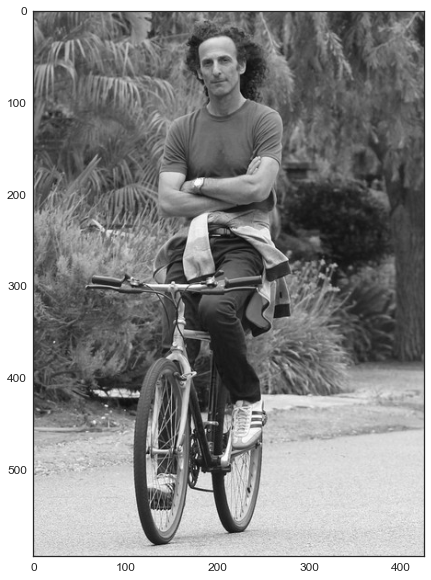

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns  # Make matplotlib colors pretty
sns.set_style("white")  # No grid
%matplotlib inline
# Need to use gray color map (cmap parameter)
plt.figure(figsize=(7, 11))
fig = plt.imshow(red, cmap=plt.cm.gray)

### Histogram of Pixel Intensities

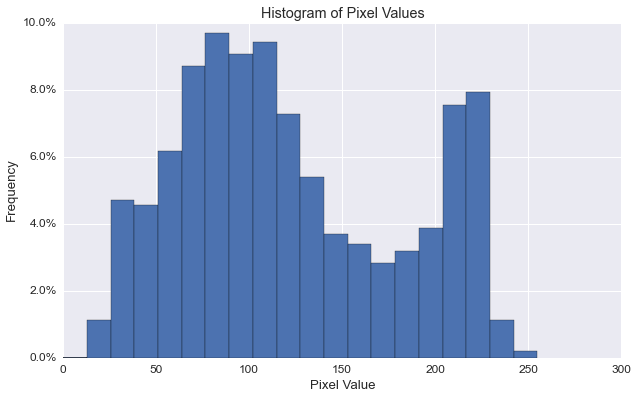

In [94]:
sns.set_style("whitegrid")
sns.set(font_scale=1.2)  # Scale up plot default font sizes
plt.figure(figsize=(10, 6))
pixels = np.ravel(red)  # Get 1D array of pixels
n, bins, patches = plt.hist(
    pixels,
    bins=20,
    histtype="bar",
    weights=np.zeros_like(pixels) + 1. / pixels.size)  # Freq.
# Make labels percentages
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda y, pos: str(y * 100) + "%")
plt.gca().yaxis.set_major_formatter(formatter)
plt.title("Histogram of Pixel Values")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

### PCA on the Image

We need to standardize the data and scale (to zero mean and unit variance) before performing PCA.

In [95]:
red.astype('float64')
red.astype('float64').dtype

dtype('float64')

In [96]:
from sklearn import preprocessing
# Make the scaler so you can transform your data
scaler = preprocessing.StandardScaler().fit(
    red.astype('float64')
)
# Transform your data using the scaler
transformed = scaler.transform(red.astype('float64'))
transformed

array([[-0.20257631, -0.37229242, -0.5286969 , ...,  0.29559093,
        -0.29992194, -0.84757654],
       [-0.39656363, -0.51000186, -0.64748122, ...,  0.48005706,
        -0.00601563, -0.67870735],
       [-0.53235475, -0.60836575, -0.687076  , ...,  0.41856835,
         0.38070321, -0.2488585 ],
       ..., 
       [ 1.36872093,  1.79171314,  1.6688131 , ...,  1.4023877 ,
         1.23148464,  1.53194388],
       [ 1.89248668,  1.94909537,  1.62921833, ...,  1.47924859,
         1.63367223,  1.43983341],
       [ 1.83429048,  1.39825759,  1.35205491, ...,  1.78669214,
         1.57179722,  1.37842643]])

Now we can run PCA.

In [97]:
from sklearn import decomposition
# Fit the model
pcomp = decomposition.PCA()
pcomp.fit(transformed)
# Check that explained variances sum to 1
var = pcomp.explained_variance_ratio_
np.sum(var)

1.0

Above, we just confirm that the explained variance ratios of the PCs sum to 1.

Let's set up a function to make our scree plots for us so we can use it later if needed. Scree plots are helpful since they visualize the explanation of variance as more principal components are used. We don't want to use all of them since at that point we might as well use the original image.

In [98]:
def scree_plot(model, xlim=[-1, 100], ylim=[-0.1, 1], required_var=0.90):
    """Make side-by-side scree plots with a marker for required minimum
    percent variance explained.
    
    Args:
        model (sklearn.decomposition.pca.PCA): A fitted sklearn
            PCA model.
        required_var (float): A required variance to be plotted
            on the scree plot. Must be between 0 and 1.
        xlim (list): X axis range, e.g. [0, 200].
        ylim (list): Y axis range.
    """
    var = model.explained_variance_ratio_
    # First plot (in subplot)
    from matplotlib.ticker import AutoMinorLocator
    plt.figure(figsize=(11, 12))
    fig = plt.subplot(2, 2, 1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot(var, marker='o', linestyle='--')
    plt.xlabel("Component Number")
    plt.ylabel("Proportion of Variance Explained")
    # Second plot
    cumsum = np.cumsum(var)  # Cumulative sum of variances
    plt.subplot(2, 2, 2)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot(cumsum, marker='o', linestyle='--')
    # Get number of components to meet required variance
    required_var_components = np.argmax(cumsum >= required_var) + 1
    plt.axvline(x=required_var_components,
                c='r',
                linestyle='dashed',
                label="> {:.0f}% Var. Explained: {} components".format(
                    required_var * 100, required_var_components)
               )
    legend = plt.legend(loc='lower right',
                        frameon=True)
    legend.get_frame().set_facecolor("#FFFFFF")
    plt.xlabel("Number of Components")
    plt.ylabel("Proportion of Variance Explained")
    # Show
    plt.show()

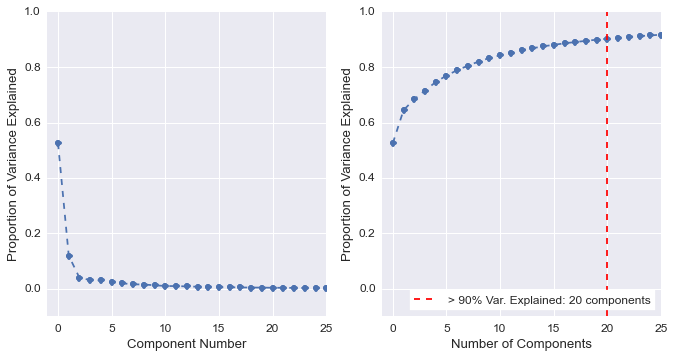

In [99]:
scree_plot(pcomp, xlim=[-1, 25], ylim=[-0.1, 1], required_var=0.90)

Note: there are more principal components than 25, but it is pointeless to show more since the variance explained by adding more is negligable.

### Projecting the Image Using PCA

We want to project the image onto _d_ principal components, where _d_ = [1, 5, 10, 15, 20, 30, 50, 100, 200]. In our previous model, we chose to keep all PCs. We could do some finagling with the model to extract just the first _d_ components to make our projections, but it's easier to train different models using the specified _d_ number of components to keep.

The line below will extend the limit of cell size before autoscrolling begins so we can see all the images below.

In [100]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

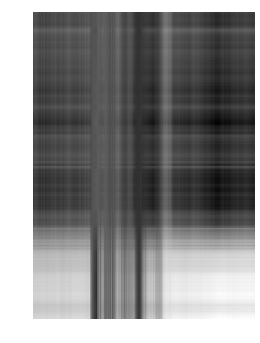

    1 components: 52.60948% variance explained


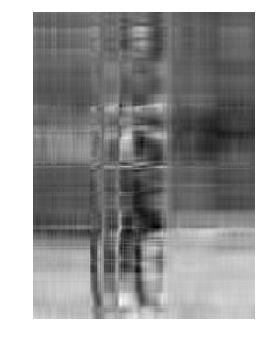

    5 components: 74.69568% variance explained


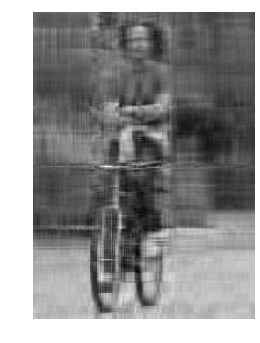

    10 components: 83.38885% variance explained


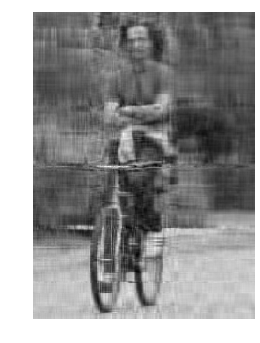

    15 components: 87.59994% variance explained


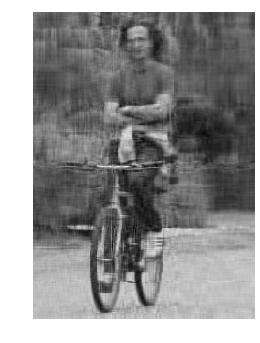

    20 components: 90.00899% variance explained


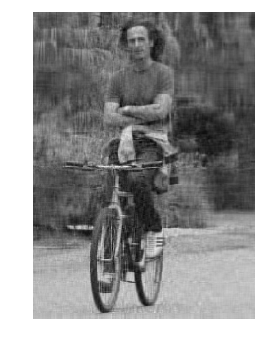

    30 components: 92.70615% variance explained


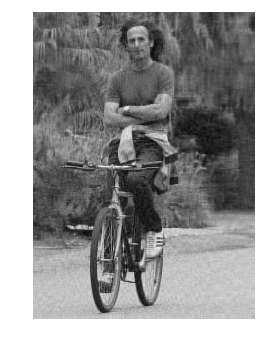

    50 components: 95.54279% variance explained


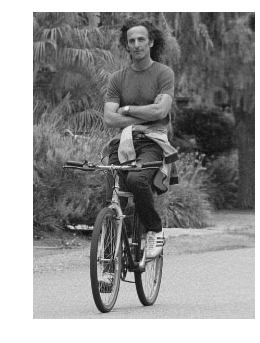

    100 components: 98.39263% variance explained


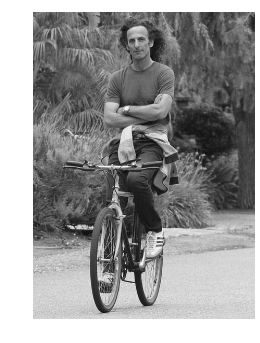

    200 components: 99.75206% variance explained


In [101]:
d = [1, 5, 10, 15, 20, 30, 50, 100, 200]
for num_comp in d:
    pcomp = decomposition.PCA(n_components=num_comp)
    # Our data is already standard scaled
    pcomp.fit(transformed)
    # Project original
    data_reduced = pcomp.transform(transformed)
    # Transform back to original space (otherwise
    # dimensions don't match orignal image since you
    # only used d components)
    projection = pcomp.inverse_transform(data_reduced)
    # Finally, let's reverse the standard scaler
    projection = scaler.inverse_transform(projection)
    # Plot the image
    plt.figure()
    plt.imshow(projection, cmap=plt.cm.gray)
    plt.axis('off')  # Remove plot ticks
    plt.show()
    # Output cumulative percentage variation explained
    var = pcomp.explained_variance_ratio_
    print ("    {} components: {:.5f}% variance "
           "explained".format(num_comp, var.sum() * 100)
          )
    

You can see that 30 components is sufficient to reconstruct a fairly good image, and with 100 components we are almost looking at the original image. Similar techniques can be used to reduce data before running regression, as we'll explore below.

## Principal Components Regression (PCR)

Let's load a file called *TCGA_example.txt* into a data array. The file contains multiple data types: string and float. Numpy arrays are single-type (except recarrarys, which I don't want to deal with right now), so let's use the Pandas library to load the data into a data frame similar to R's data frames. Pandas' data frames allow multiple data types.

The data contains gene expression levels for 1999 genes from 217 patients. These patients either have "Luminal A" or "Basal" breast cancer, and are labeled "Normal" and "Basal", respectively.

In [102]:
import pandas as pd
tcga = pd.read_csv("TCGA_example.txt", sep=" ")
type(tcga)

pandas.core.frame.DataFrame

Let's check that the data got loaded correctly.

In [103]:
tcga.columns.values

array(['Subtype', 'Gene.1', 'Gene.2', ..., 'Gene.1998', 'Gene.1999',
       'Gene.2000'], dtype=object)

In [104]:
tcga.Subtype.head()

1    Basal
2    Basal
3    Basal
4    Basal
5    Basal
Name: Subtype, dtype: object

In [105]:
tcga.dtypes.head()

Subtype     object
Gene.1     float64
Gene.2     float64
Gene.3     float64
Gene.4     float64
dtype: object

The _Subtype_ column should be a string, but in fact the _object_ type is a string: it's holding strings of variable length, unlike Numpy which requires each cell to occupy the same amount of bytes in memory.

In [106]:
# Need to index cols as string now (rather than dot
# notation used above) since headers have periods
# in them.
tcga['Gene.1'].head()

1    0.589312
2    0.180408
3    0.500461
4   -0.014082
5    0.025982
Name: Gene.1, dtype: float64

In [107]:
tcga.shape

(217, 2001)

Set our features and targets up now that we know the data is loaded correctly. We'll take the preliminary step here of casting the types to Numpy ndarrays so that we can use them with scikit-learn. We'll predict the expression of the first gene using the other 1999 gene expression levels.

In [108]:
import numpy as np
tumor_types = np.array(tcga['Subtype'].values, dtype=str)
# Note: Pandas [:3] type of slicing defaults to row slicing.
# Use .iloc[] method instead. Also, their indexing is
# [x1, x2)...include/exclude.
y = np.array(tcga.iloc[:, 1], dtype='float64')  # 1th (2nd) column
X = tcga.iloc[:, 2:].as_matrix()

### Perform PCA on the Data

In [109]:
from sklearn.cross_validation import train_test_split
# We're going to want to color some plots based on tumor type later,
# so we'll use that as our y for our train/test split:
X_train, X_test, t_train, t_test = train_test_split(X, tumor_types,
                                                    train_size=0.8,
                                                    random_state=1)
# Set up scaler for the data
scaler = preprocessing.StandardScaler().fit(X_train)
# Transform the data using the scaler
transformed = scaler.transform(X_train)
# Run PCA
pcomp = decomposition.PCA()
pcomp.fit(transformed)

PCA(copy=True, n_components=None, whiten=False)

We can use the function we made earlier to make our scree plots.

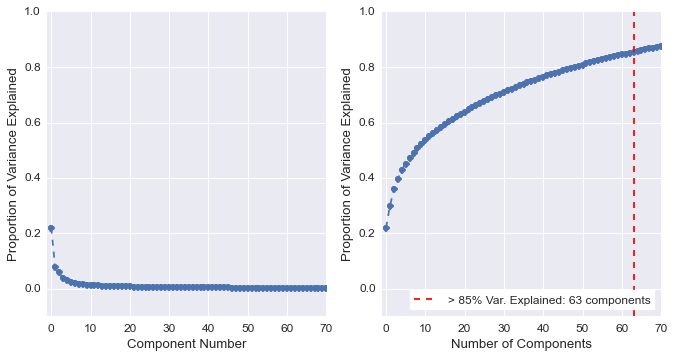

In [110]:
scree_plot(pcomp, xlim=[-1, 70], ylim=[-0.1, 1], required_var=0.85)

Make scatter plot of first four PCs.

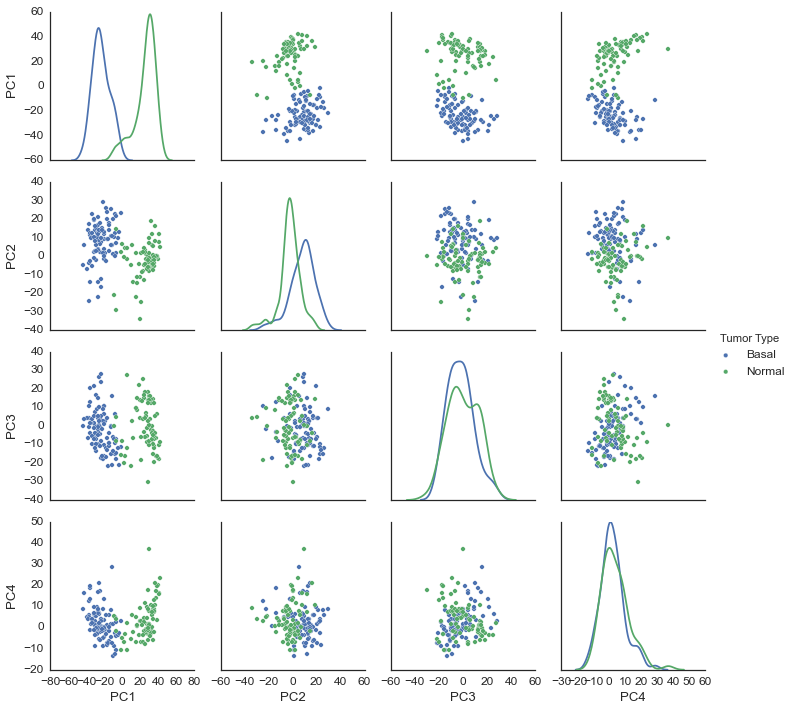

In [111]:
# Note: eigen vectors in pcomp.components_
X_train_projection = pcomp.transform(X_train)
# Now take the first four columns of the projections to plot
df = pd.DataFrame(X_train_projection[:, 0:4],
                  columns=["PC1", "PC2", "PC3", "PC4"])
df['Tumor Type'] = t_train  # Add the labels
sns.set_style("white")
sns.pairplot(df, hue="Tumor Type", diag_kind='kde')
# More fancy plotting options here:
# http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html

PC1 against all other PCs generates plots with clear distinctions between tumor types. It explains ~22% of the variance, whereas the other PCs only explain ~3% to 8% of the variance. As we move up to PC4, which only adds ~3% variance explained, we can see that the densitity functions of different tumor types begin to overlap, meaning that the likelihood of seeing a Basal or Normal tumor type start to follow the same PDF; this makes it harder to distinguish between Basal and Normal tumor types, and demonstrates how the variance in data decreases as we increment which PC we look at.

### Principal Components Regression (PCR)

Now we'll run PCR on the data, but since scikit-learn doesn't have a single function for PCR we'll have to roll our own by first doing PCA then OLS regression. We want to use 10-fold cross-validation to determine the best number of PCs to use using minimum MSPE as our selection parameter. We'll be using the _y_ variable we created above as our targets.

In [112]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

def pcr(X, y, num_components, k=10, seed=None):
    """Runs principal components regression using k-fold cross
    validation.
    
    Args:
        X (numpy.ndarray): Feature data, n x p matrix.
        y (numpy.ndarray): Targets, n x 1 numeric response.
        num_components (int): Number of PCs to keep prior to OLS.
        k (int): Number of folds for cross-validation.
    
    Returns:
        (tuple): A tuple containing (average MSPE for
            test data, average MSPE for training data).
    """
    np.random.seed(seed)
    # Build your sampler
    sampler = np.arange(y.shape[0])
    np.random.shuffle(sampler)
    # Create folds for cross-validation
    folds = np.array_split(sampler, k)
    # Set up vars to store our outputs
    mse = np.zeros(k, dtype=np.float)
    mspe = np.zeros(k, dtype=np.float)
    # Perform PCA and linear regression
    for i in range(len(folds)):
        # Split training and test data for CV
        train_indx = np.concatenate(folds[:i] + folds[(i + 1):])
        test_indx = folds[i]
        x_train, y_train = (X[train_indx, :], y[train_indx])
        x_test, y_test = (X[test_indx, :], y[test_indx])
        # Scale, fit PCA, and reduce x
        scaler = preprocessing.StandardScaler().fit(x_train)
        transformed = scaler.transform(x_train)
        pcomp = decomposition.PCA(n_components=num_components)
        pcomp.fit(transformed)
        x_train_projection = pcomp.transform(transformed)
        # Apply the PCA model to scaled x_test
        x_test_transformed = scaler.transform(x_test)
        x_test_projection = pcomp.transform(x_test_transformed)
        # Now run regression
        ols = linear_model.LinearRegression()
        ols.fit(x_train_projection, y_train)
        # Get MSE of training set
        y_pred_train = ols.predict(x_train_projection)
        mse[i] = mean_squared_error(y_train, y_pred_train)
        # Get MSPE of test set
        y_pred_test = ols.predict(x_test_projection)
        mspe[i] = mean_squared_error(y_test, y_pred_test)
    return mspe.mean(), mse.mean()

Even though we split into training and test data within our function for cross-validation, we want to split the data up into training and test data before running CV. Internally, the function above will use CV on our test set to help us pick a model. In the end, we'll use the held-out test set that doesn't get sent to the function to test our final model.

In [113]:
# Make sure to seed the function so we get the same CV samples
# every time. Let's go up to 155 principal components (I think
# we end up with ~163 after fitting PCA using all columns).
cv_mses = []
cv_mspes = []
num_comps = range(1, 155)
# Train test split: use 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=1)
# Run PCR using different number of PCs
for i in num_comps:
    avg_mspe, avg_mse = pcr(X_train, y_train, num_components=i,
                            k=10, seed=1)
    cv_mses.append(avg_mse)
    cv_mspes.append(avg_mspe)

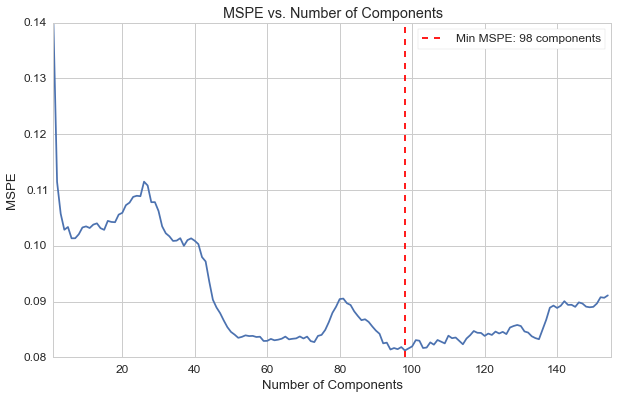

In [114]:
# Plot the data
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(num_comps, cv_mspes)
min_mspe_indx = np.argmin(cv_mspes)
plt.axvline(x=num_comps[min_mspe_indx],
            c='r',
            linestyle='dashed',
            label="Min MSPE: {} components".format(
                num_comps[min_mspe_indx])
           )
legend = plt.legend(loc='upper right', frameon=True)
legend.get_frame().set_facecolor("#FFFFFF")
plt.xlim([1, len(num_comps) + 1])
plt.title("MSPE vs. Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("MSPE")

The MSPE inceases as number of components increases, until a point, after which the trend reverses. This is because the PCA model is fit using the _training_ data. It serves to dimension-reduce X by way of representing it using its eigenvector matrix. If too many PCs are used, that matrix starts to become too specific to the X data rather than explaining the general variance in all our data (training and test combined). In a way, the PCA becomes overfit, reducing our test set to unideal values. Thus, it is not the regression itself that causes the MSPE to increase after 98 components are used, but rather the PCA transformation built using the training set that is applied to the test causes the increase.

Note that if we run PCR on the entire data set (not shown here) MSPE suggests we should use 133 components.

For this regression, we should choose PCR with 98 components. If we simply wanted to capture a threshold of explained variance before applying regression we would use 63 components, which cummulatively explain 85% of the variance. However, since we're going for predictive power, we use 98 components.

Let's finally build a model using these parameters on the full data set so we can get our parameter estimates. We can't use the function we created earlier since that applies cross-validation.

In [115]:
scaler = preprocessing.StandardScaler().fit(X_train)
transformed = scaler.transform(X_train)
pcomp = decomposition.PCA(n_components=98)
pcomp.fit(transformed)
x_train_projection = pcomp.transform(transformed)
# Apply the PCA model to scaled x_test
x_test_transformed = scaler.transform(X_test)
x_test_projection = pcomp.transform(x_test_transformed)
# Now run regression
ols = linear_model.LinearRegression()
ols.fit(x_train_projection, y_train)
# Get MSE of training set
y_pred_train = ols.predict(x_train_projection)
mse = mean_squared_error(y_train, y_pred_train)
# Get MSPE of test set
y_pred_test = ols.predict(x_test_projection)
mspe = mean_squared_error(y_test, y_pred_test)

### MSE and MSPE of Final Model

In [116]:
print "MSE: {}".format(mse)
print "MSPE: {}".format(mspe)

MSE: 0.0181005672179
MSPE: 0.0719613794587


For almost any other predictive model (especially classifiers) we'd probably want to create our classifier using the PCA-reduced space so we're not using all of the original data. Since we're using regression, the assumption here is we want interpretability, so after making the projections of our X using PCA, we either want to:

1. then bring our data back to the original space and undo the scaling so we can regress in the original X space,
2. or instead regress in PC space, determine the coefficients for the PCs, then use those PC coefficients to obtain the corresponding beta coefficients. Any new data (e.g. test) needs to be scaled and transformed using the same scaler and PCA models that were fitted on the training set.

The first approach (reducing our X via PCA then transforming it back to the original space to regress) did not work. Doing this looks something like:

```python
pcomp.fit(transformed)  # Use scaled x_train data
x_train_projection = pcomp.transform(transformed)
# Bring the data back to the original space and unscale
x_train_reduced = pcomp.inverse_transform(x_train_projection)
x_train_reduced = scaler.inverse_transform(x_train_reduced)
# Regress in original X space
ols = linear_model.LinearRegression()
ols.fit(x_train_reduced, y_train)
```

The code above successfully gets `x_train_reduced` to have the original 1999 columns seen in the original data, however it only has 22 rows, presumably because the rest of the rows contain almost no additional information after transformation...? I would have to look at the source code to see how the `inverse_transform()` is implemented to get back to the original X space.

Therefore, we must run regression in the projection space, as in the second approach above. The end result is that the regression coefficients are for that space, and we lose interpretability of the terms unless we can convert the PC coefficients to beta coefficients. We can rotate the PC coefficients to get back to coefficients that correspond with the original features. If we define **A** to be the PC coefficients, **B** to be the beta coefficients, and **P** as the loadings for _X_, we should be able to get **B** by:

$$B = P^TA$$

In [117]:
print ols.coef_.shape  # PC coefficients (eigen vector matrix)
print pcomp.components_.shape  # Loadings

(98,)
(98, 1999)


In [118]:
beta_coeffs = np.dot(ols.coef_, pcomp.components_)
beta_coeffs.shape

(1999,)

It looks like we have 1999 coefficients now, corresponding to the beta coefficients in the original X space for the 1999 parameters we had. We just used the equation $$B = AP$$ rather than transposing **P**, which yields the same result.

The final coefficients obtained via this method are below.

In [119]:
cols = tcga.columns.values[2:]
results = {'Coeffs': pd.Series(beta_coeffs, index=cols)}
df = pd.DataFrame(results)
print df[:15]  # Only show first 15 coefficients

           Coeffs
Gene.2  -0.001353
Gene.3  -0.000923
Gene.4   0.002818
Gene.5   0.001826
Gene.6   0.002566
Gene.7   0.005538
Gene.8  -0.002406
Gene.9   0.001275
Gene.10 -0.001495
Gene.11 -0.002327
Gene.12 -0.000870
Gene.13  0.001802
Gene.14  0.000910
Gene.15  0.000077
Gene.16 -0.000450


In [120]:
# Intercept in PC space
ols.intercept_

-0.061860959537572258

We still have a PC-space intercept that we need to account for. But, in fact, that intercept is the same in the PC space as it is for the original X space. So to predict our data in the real space we can use that same intercept:

$$B_i \cdot X_i + B_0$$

Here, $B_i$ is the real-space coefficients we determined above, and $B_0$ is the OLS intercept from the PC space.

Here are two examples of predicting y using our real-space coefficients:

In [121]:
np.dot(beta_coeffs, X_test[0, :]) + ols.intercept_  # Prediction

0.030742386406495417

In [122]:
y_test[0]  # Actual

-0.30155799999999999

This is one prediction, for the first data point (row) in our X test set. The second row can be predicted by:

In [123]:
np.dot(beta_coeffs, X_test[1, :]) + ols.intercept_  # Prediction

-0.21705034214658026

And the actual value for that y:

In [124]:
y_test[1]  # Actual

-0.168324

Finally, we can compare the R<sup>2</sup> value using the training set for both the PCR (i.e. regression on the principal components) and using our coefficients above for the original X space.

### R<sup>2</sup> for PCR

In [125]:
ols.score(x_train_projection, y_train)

0.87207525067136626

### R<sup>2</sup> Using Real-Space Coefficients

In [126]:
y_pred = np.zeros(X_train.shape[0], dtype='float')
for i in range(X_train.shape[0]):
    y_pred[i] = np.dot(beta_coeffs, X_train[i, :]) + ols.intercept_

In [127]:
from sklearn.metrics import r2_score
r2_score(y_train, y_pred)

0.80041207512425183

We can see that the R<sup>2</sup> obtained by staying in the PCA space is better than using our calculated real-space coefficients. So, to make predictions, rather than using the obtained X-space coefficients we would probably want to scale and perform PCA on our new data, then run it through our "PCR model". The benefit of the real-space coefficients, however, is that they give us some interpretability about the impact of each feature on the predictions.